In [254]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os

In [252]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [253]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

## **Define Functions for Simulations**

In [79]:
class BurstModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    """
    def __init__(self,seq_model='None',quad_method='fixed_quad',fixed_quad_T=10,quad_order=60,quad_vec_T=np.inf):
        self.seq_model = seq_model
        self.quad_method = quad_method
        self.fixed_quad_T = fixed_quad_T
        self.quad_order = quad_order
        self.quad_vec_T = quad_vec_T
        
    def burst_intfun(self, x, g, b, beta, gamma):
        if np.isclose(beta, gamma):
            c_1 = g[0]  
            c_2 = x * beta * g[1]
        else:
            f = beta / (beta - gamma)
            c_2 = g[1] * f
            c_1 = g[0] - c_2

        U = b * (np.exp(-beta * x) * c_1 + np.exp(-gamma * x) * c_2)
        return U / (1 - U)    
    
    def eval_model_pgf(self, p_, g):
        p = 10**p_
        b, beta, gamma = p
        fun = lambda x: self.burst_intfun(x, g, b, beta, gamma)
        if self.quad_method == "quad_vec":
            T = self.quad_vec_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.quad_vec(fun, 0, T)[0]
        elif self.quad_method == "fixed_quad":
            T = self.fixed_quad_T * (1 / beta + 1 / gamma + 1)
            gf = scipy.integrate.fixed_quad(fun, 0, T, n=self.quad_order)[0]
        else:
            raise ValueError("Please use one of the specified quadrature methods.")
        return gf  # this is the log-generating function

    def get_Pss(self, p, limits, samp=None):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1
        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        g = np.asarray(g)[:, :, None]

        if self.seq_model == "Bernoulli":
            g *= np.asarray(samp)[:, None, None]
        elif self.seq_model == "Poisson":
            g = np.exp((np.power(10, samp))[:, None, None] * g) - 1

        gf = self.eval_model_pgf(p, g)
        gf = np.exp(gf)
        gf = gf.reshape(tuple(mx))
        Pss = scipy.fft.irfftn(gf, s=tuple(limits))
        Pss = np.abs(Pss) / np.sum(np.abs(Pss))
        Pss = Pss.squeeze()
        return Pss

In [80]:
def sample_from_p(num_data_points, Pss):
    mx = Pss.shape
    p_flat = Pss.flatten()
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = np.random.choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M

In [81]:
def get_logL_2d(data,model,bp,m_N,m_M,sr,mx,bp_is_bpn=True):
    d0,d1=data
    Pss = Pss_at_sr(model,bp,m_N,m_M,sr,mx,bp_is_bpn)
    logL = np.sum(np.log(Pss[d0,d1]))
    return logL

def Pss_at_sr(model,bp,m_N,m_M,sr,mx,bp_is_bpn=True):
#     print(bp_is_bpn)
    if sr<1:
        pn = 1
        pm = sr
    else:
        pm = 1
        pn = 1/sr
    if bp_is_bpn:
        b = bp/pn
        beta = bp/m_N
        gamma = b*pm/m_M
    else:
        b = bp/pm
        gamma = bp/m_M
        beta = b*pn/m_N
    samp = [pn,pm]
    p = np.log10([b,beta,gamma])
    return model.get_Pss(p,mx,samp)

## **Generate Counts**

In [283]:
#No. of cells per k cell 'type'
n_cells = 500
clus = 3

In [284]:
n_genes = 100
num_marks = 10

In [285]:
transcriptome = pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header = None)
transcriptome.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,TNMD,14950,48,23,10,5,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1,DPM1,23689,98,38,25,17,10,6,5,5,...,0,0,0,0,0,0,0,0,0,0
2,SCYL3,44637,132,51,20,13,9,7,6,4,...,0,0,0,0,0,0,0,0,0,0
3,TSPAN6,12884,43,18,13,8,3,2,2,1,...,0,0,0,0,0,0,0,0,0,0
4,FGR,23122,41,18,8,4,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [286]:
#Select gene lengths from human transcriptome
gene_names = np.array(transcriptome[0])
gene_lens = np.array(transcriptome[1])

choices = random.sample(range(len(gene_names)), n_genes)
names_sub = gene_names[choices]
lens_sub = gene_lens[choices]

In [287]:
#For each gene set params (clus x n_genes x 6), use gene lens from transcriptome file + use same gene names 
params = np.zeros((clus,n_genes,6)) #b,k,beta,gamma,samp_n,samp_m
for g in range(n_genes):
    g_len = lens_sub[g]
    params[:,g,0] = int(np.random.uniform(8,15))
    params[:,g,1] = np.random.uniform(0.1,0.5)
    params[:,g,2] = 1
    params[:,g,3] = np.random.normal(0.8,0.1)
    
    params[:,g,4] = 10**(-7.157894736842105)*g_len
    params[:,g,5] = 10**(-1.525)
    


#For each clus, select 10 unique markers, add noise to b (log10b)
all_choices = np.random.choice(range(n_genes), num_marks*clus, replace=False)
for c in range(clus):
    marks = all_choices[c*num_marks:(c+1)*num_marks]
    
    params[c,marks,0] = 10**(np.log10(params[c,marks,0]) + np.random.normal(loc=1.0, scale = 0.1, size=len(marks))) #Only in burst size for now



In [288]:
#For each clus get n_cells samples + concat, 
all_counts = np.zeros((clus*n_cells,n_genes,2))
for c in range(clus):
    
    for g in range(n_genes):
        
        b = params[c,g,0]
        k = params[c,g,1]
        beta = params[c,g,2]
        gamma = params[c,g,3]
        
        samp = [params[c,g,4], params[c,g,5]]

        p = np.log10(np.asarray([b,beta/k,gamma/k]))
        burst_model = BurstModel('Poisson')

        max_mean = b*k*np.asarray([1/beta,1/gamma])
        max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))
        max_domain = max_mean + 4*max_std
        max_domain = [int(i) for i in max_domain]

        Pss = burst_model.get_Pss(p,max_domain,samp)

        #Get samples
        all_counts[c*n_cells:(c+1)*n_cells,g,0] = sample_from_p(n_cells, Pss)[0]
        all_counts[c*n_cells:(c+1)*n_cells,g,1] = sample_from_p(n_cells, Pss)[1]





In [289]:
# !mkdir ~/counts/mixMod_sims
# !mkdir ~/counts/mixMod_sims/loom/

**Save count matrices for Monod**

In [290]:
#And save clus labels for cells + barcodes for each cell in metadata + loom
out_path = '/home/tchari/counts/mixMod_sims/loom/'
U = all_counts[:,:,0]
S = all_counts[:,:,1]
geneNames = names_sub
bars = [str(i) for i in range(n_cells*clus)]

fname = out_path+'burst_mark_sim.loom'

print('Making Loom')
#Make loom of U/S
retAdata = anndata.AnnData(
			X=sparse.csr_matrix(S),
			layers={
				'spliced': sparse.csr_matrix(S),
				'unspliced': sparse.csr_matrix(U),
			},
			obs=pd.DataFrame({'barcode': np.array(bars)},index=np.array(bars)),
			var=pd.DataFrame({'gene_name': geneNames},index=geneNames)
		)

retAdata.write_loom(fname)


Making Loom


/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [291]:
#Check loom ok
import loompy as lp
ds = lp.connect('/home/tchari/counts/mixMod_sims/loom/burst_mark_sim.loom')

In [292]:
ds

,,barcode,0,1,2,3,4,5,6,7,8,9,...
,,obs_names,0,1,2,3,4,5,6,7,8,9,...
gene_name,var_names,,,,,,,,,,,,...
AC007274.3,AC007274.3,,5.0,0.0,3.0,2.0,0.0,7.0,3.0,4.0,5.0,1.0,...
SYNE4,SYNE4,,0.0,5.0,0.0,5.0,0.0,3.0,4.0,0.0,4.0,12.0,...
AP002800.2,AP002800.2,,1.0,14.0,16.0,22.0,0.0,16.0,5.0,9.0,13.0,0.0,...
AC010655.5,AC010655.5,,3.0,17.0,6.0,0.0,1.0,0.0,18.0,0.0,0.0,9.0,...
AC068725.1,AC068725.1,,15.0,8.0,12.0,2.0,1.0,13.0,0.0,9.0,0.0,7.0,...
IKBKE,IKBKE,,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,...
LINC01179,LINC01179,,0.0,0.0,0.0,3.0,0.0,20.0,0.0,13.0,0.0,0.0,...
AC011472.1,AC011472.1,,0.0,0.0,0.0,2.0,16.0,6.0,5.0,3.0,2.0,0.0,...


In [293]:
ds.close()

In [294]:
#All params from sim, for comparison to fits (for each gene)
params.shape

(3, 100, 6)

**Check clarity of assignment first**

In [389]:

concat_types = np.concatenate((np.mean(all_counts[0:500,:,:],axis=0),np.mean(all_counts[500:1000,:,:],axis=0),
          np.mean(all_counts[1000:1500,:,:],axis=0)),axis=1)


[Text(1, 0.5, '74'),
 Text(1, 1.5, '15'),
 Text(1, 2.5, '48'),
 Text(1, 3.5, '11'),
 Text(1, 4.5, '33'),
 Text(1, 5.5, '94'),
 Text(1, 6.5, '40'),
 Text(1, 7.5, '86'),
 Text(1, 8.5, '19'),
 Text(1, 9.5, '73'),
 Text(1, 10.5, '27'),
 Text(1, 11.5, '96'),
 Text(1, 12.5, '17'),
 Text(1, 13.5, '69'),
 Text(1, 14.5, '45'),
 Text(1, 15.5, '65'),
 Text(1, 16.5, '36'),
 Text(1, 17.5, '88'),
 Text(1, 18.5, '0'),
 Text(1, 19.5, '4'),
 Text(1, 20.5, '12'),
 Text(1, 21.5, '13'),
 Text(1, 22.5, '39'),
 Text(1, 23.5, '67'),
 Text(1, 24.5, '82'),
 Text(1, 25.5, '58'),
 Text(1, 26.5, '81'),
 Text(1, 27.5, '85'),
 Text(1, 28.5, '53'),
 Text(1, 29.5, '60'),
 Text(1, 30.5, '42'),
 Text(1, 31.5, '46'),
 Text(1, 32.5, '24'),
 Text(1, 33.5, '43'),
 Text(1, 34.5, '7'),
 Text(1, 35.5, '41'),
 Text(1, 36.5, '10'),
 Text(1, 37.5, '57'),
 Text(1, 38.5, '83'),
 Text(1, 39.5, '5'),
 Text(1, 40.5, '50'),
 Text(1, 41.5, '80'),
 Text(1, 42.5, '25'),
 Text(1, 43.5, '54'),
 Text(1, 44.5, '37'),
 Text(1, 45.5, '56'),
 T

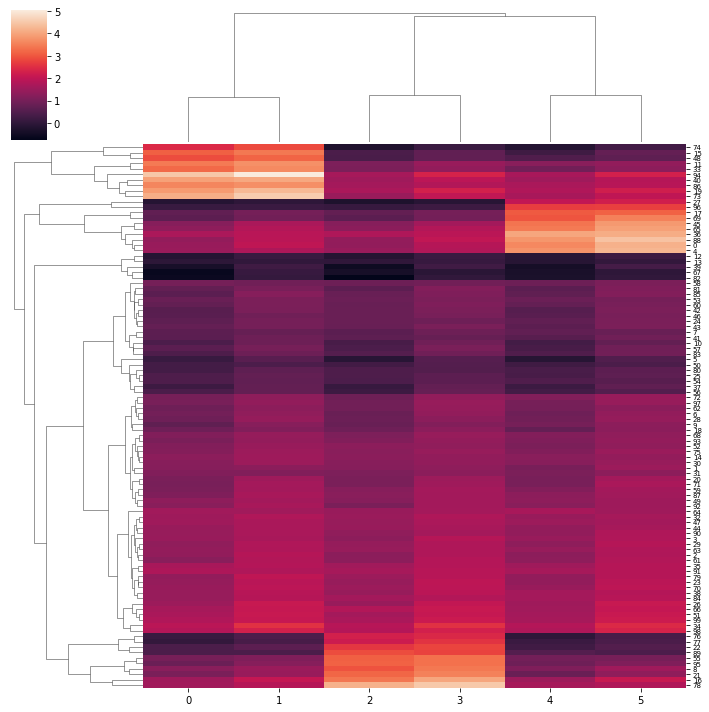

In [390]:
g = sns.clustermap(np.log(concat_types),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)


## **Run Inference**

In [295]:
#Save cell cluster assigns and marker genes
true_clus = []
true_marks = []
for i in range(clus):
    true_clus += [list(np.array(bars)[i*n_cells:(i+1)*n_cells])]
    true_marks += [list(all_choices[i*num_marks:(i+1)*num_marks])]
    


In [296]:
true = pd.DataFrame()
true['clus'] = range(clus)
true['cells'] = true_clus
true['marks'] = true_marks
true.head()

,clus,cells,marks
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[94, 11, 33, 48, 19, 40, 86, 74, 73, 15]"
1,1,"[500, 501, 502, 503, 504, 505, 506, 507, 508, ...","[21, 78, 16, 95, 55, 77, 89, 76, 22, 8]"
2,2,"[1000, 1001, 1002, 1003, 1004, 1005, 1006, 100...","[65, 88, 27, 17, 96, 4, 36, 45, 69, 0]"


In [297]:
dataset_meta = ['burst_mark_sim']
print('dataset_meta: ', dataset_meta)
print()



cluster_names = []
dataset_names = ['burst_mark_sim_'+'20230330']   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = ['burst_mark_sim']
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/mixMod_sims/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['burst_mark_sim']

dataset_names:  ['burst_mark_sim_20230330']
len(dataset_names):  1

loom_filepaths:  ['/home/tchari/counts/mixMod_sims/loom/burst_mark_sim.loom']


Dataset burst_mark_sim. 
	1500 barcodes in loom, 1419 pass filter. 1500 in annotations; of these, 1500 in loom and 1419 in filtered loom.
	All: 1500 cells in annotations. 1500 in loom. 1419 pass filter.
mkdir: cannot create directory ‘./figs’: File exists


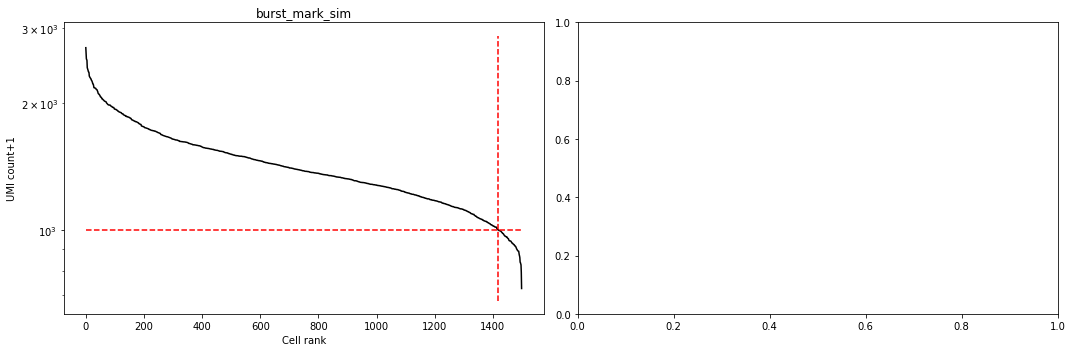

In [298]:
#MAYBE SKIP FILTER FOR NOW
cf = []
thr_lb = [1e3]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = raw_data_locations[k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = len(bcs)
        annot_bcs_in_loom = len(bcs)
        annot_bcs_in_filt_loom = cf_.sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        #for subcluster in subcluster_names:
        subcluster = 'All'
        annot_bcs = bars
        cf.append(np.isin(bcs,annot_bcs) & cf_)
        print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_burst_mark_sim_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [299]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [300]:
#Define bounds, from 20220930_normanfit_monod.ipynb
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.157894736842105, -1.525] #-7.5, -2
samp_ub = [-7.157894736842105, -1.525] #-5.5, 0
# gridsize = [5,6]
gridsize = [1,1]


(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

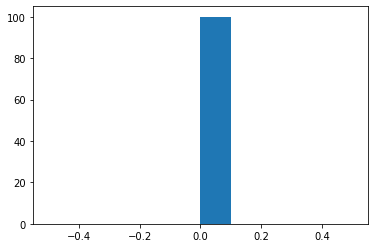

In [301]:
plt.hist(np.log10(params[1,:,2]))

In [302]:
k=3
epochs=10

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230330_025_burst_mark_sim_MM_k3_1 created.
INFO:root:Dataset: burst_mark_sim_20230330
INFO:root:1419 cells detected.
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:97 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230330_025_burst_mark_sim_MM_k3_1/burst_mark_sim_20230330 created.
INFO:root:Total of 100 genes selected.
INFO:root:Directory ./fits/gg_230330_025_burst_mark_sim_MM_k3_1/diagnostic_figures created.


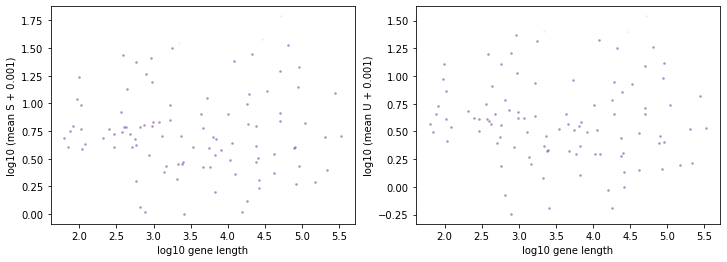

In [303]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='burst_mark_sim_MM_k3',batch_id=1,\
                                             n_genes=100,exp_filter_threshold=None,cf=cf)

INFO:root:Directory ./fits/gg_230330_025_burst_mark_sim_MM_k3_1/burst_mark_sim_20230330/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230330_025_burst_mark_sim_MM_k3_1/burst_mark_sim_20230330/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: burst_mark_sim_20230330
INFO:root:100 features observed, 100 match genome annotations. 100 were unique.
INFO:root:Gene list extracted from ./fits/gg_230330_025_burst_mark_sim_MM_k3_1/genes.csv.
INFO:root:Directory ./fits/gg_230330_025_burst_mark_sim_MM_k3_1/burst_mark_sim_20230330/diagnostic_figures already exists.
INFO:root:Search data stored to ./fits/gg_230330_025_burst_mark_sim_MM_k3_1/burst_mark_sim_20230330/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:21<00:00, 147.33s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:36<00:00, 132.19s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.34004218 0.45798473 0.20197309]
logL:  -664.5770963971702
INFO:root:EM Epoch 2/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [08:18<00:00, 166.05s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.50851615 0.32377812 0.16770573]
logL:  -671.1041147948486
INFO:root:EM Epoch 3/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:49<00:00, 136.48s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.5287686 0.1967576 0.2744738]
logL:  -670.0567462019711
INFO:root:EM Epoch 4/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:50<00:00, 136.75s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.40098319 0.26987612 0.32914069]
logL:  -668.7684456827918
INFO:root:EM Epoch 5/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:57<00:00, 159.23s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.3947386  0.30356014 0.30170126]
logL:  -674.0314612029089
INFO:root:EM Epoch 6/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [08:22<00:00, 167.44s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.44202604 0.36902373 0.18895023]
logL:  -670.4174841463247
INFO:root:EM Epoch 7/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:15<00:00, 105.02s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.46835854 0.38941134 0.14223012]
logL:  -664.4399754367914
INFO:root:EM Epoch 8/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:34<00:00, 71.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.43402964 0.34694208 0.21902828]
logL:  -664.0920068528987
INFO:root:EM Epoch 9/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:20<00:00, 126.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.4050004  0.31323311 0.28176649]
logL:  -670.9846533502807
INFO:root:EM Epoch 10/10: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:59<00:00, 99.98s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.35472757 0.3804633  0.26480913]
logL:  -669.8839634180239
INFO:root:Non-parallelized grid scan complete.


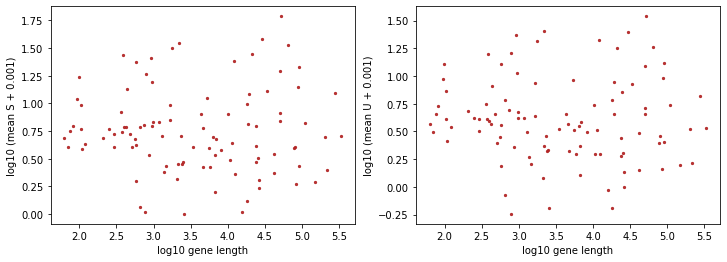

In [307]:
result_strings = []
for i in range(0,1): #n_datasets
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=k,epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


['./fits/gg_230330_025_burst_mark_sim_MM_1/burst_mark_sim_20230330']

In [355]:
import pickle 
with open("/home/tchari/perturbCME/notebooks/fits/gg_230330_025_burst_mark_sim_MM_k3_1/burst_mark_sim_20230330/Bursty_Poisson_1x1/grid_point_0.gp", "rb") as ipfs:
    grid_point_results_k3 = pickle.load(ipfs)
    

In [371]:
cell_res = pd.DataFrame()
assigns = grid_point_results_k3.assigns
cluster = []
assign = []
for i in range(clus-1):
    cluster += [i]*n_cells
    assign += list(grid_point_results_k3.assigns[i*n_cells:(i+1)*n_cells])
    
cell_res['cluster'] = cluster
cell_res['assign'] = assign
cell_res.head()

,cluster,assign
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


Text(0.5, 0, 'MM Assignment')

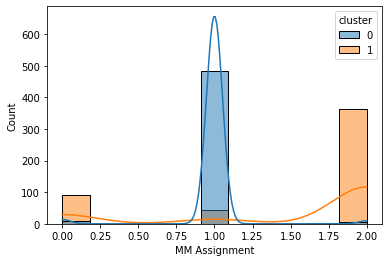

In [373]:
sns.histplot(data=cell_res, x="assign",hue='cluster', kde=True)
plt.xlabel('MM Assignment')

Text(0, 0.5, 'NLL')

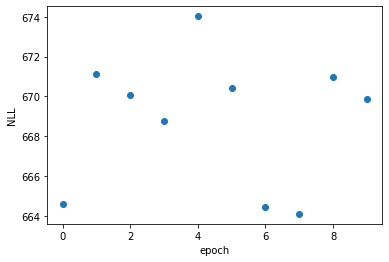

In [324]:
plt.scatter(range(len(grid_point_results_k3.all_bounds)),-1*np.array(grid_point_results_k3.all_bounds))
plt.xlabel('epoch')
plt.ylabel('NLL')

In [374]:
grid_point_results_k3.aic #Compare with k = 2

1902934.6881803519

In [375]:
#Compare parameter fits, gene x param x k
grid_point_results_k3.param_estimates.shape

(100, 3, 3)

In [383]:
b0 = grid_point_results_k3.param_estimates[:,0,1]
b1 = grid_point_results_k3.param_estimates[:,0,2]

In [384]:
true_b0 = params[0,:,0]
true_b1 = params[1,:,0]

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

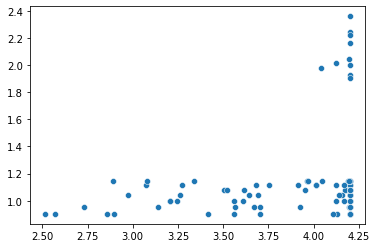

In [386]:
sns.scatterplot(b0,np.log10(true_b0))

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

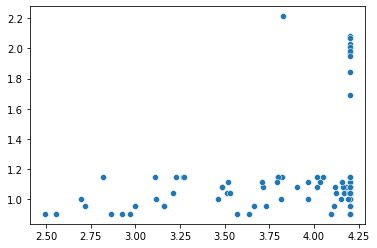

In [387]:
sns.scatterplot(b1,np.log10(true_b1))

In [85]:
#Init values per gene

np.random.seed(42)

b=10 #10
k = 0.2 #0.2 
beta = 1 #1
gamma = 0.8 #0.8
samp = [0.008,10**(-1.525)] #[0.4,0.5], from data 10**(-7.157894736842105)*len + 10**(-1.525) 




In [86]:
#Get PSS for gene
p = np.log10(np.asarray([b,beta/k,gamma/k]))
burst_model = BurstModel('Poisson')

max_mean = b*k*np.asarray([1/beta,1/gamma])
max_std = np.sqrt(max_mean*(1+ b*np.asarray([1,beta/(beta+gamma)])))
max_domain = max_mean + 4*max_std
max_domain = [int(i) for i in max_domain]

Pss = burst_model.get_Pss(p,max_domain,samp)

#Get samples
test = sample_from_p(100, Pss)


[20, 18]


In [281]:
all_counts.shape

(1500, 100, 2)

In [187]:
all_choices

array([16, 94, 30, 72, 63, 66, 62, 92, 26, 38, 73, 82, 40, 87, 42,  0,  5,
        3, 59, 24, 61, 99, 44, 45, 88, 93, 13, 20, 37, 34])

Text(0, 0.5, 'Mature counts')

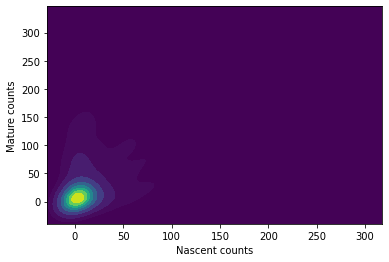

In [305]:
plt.figure()
test = all_counts[:,0]
sns.kdeplot(x=test[:,0], y=test[:,1], cmap="viridis", shade=True, thresh=0)
plt.xlabel('Nascent counts')
plt.ylabel('Mature counts')


In [331]:

concat_types = np.concatenate((np.mean(all_counts[0:500,:,:],axis=0),np.mean(all_counts[500:1000,:,:],axis=0),
          np.mean(all_counts[1000:1500,:,:],axis=0)),axis=1)


[Text(1, 0.5, '74'),
 Text(1, 1.5, '15'),
 Text(1, 2.5, '48'),
 Text(1, 3.5, '11'),
 Text(1, 4.5, '33'),
 Text(1, 5.5, '94'),
 Text(1, 6.5, '40'),
 Text(1, 7.5, '86'),
 Text(1, 8.5, '19'),
 Text(1, 9.5, '73'),
 Text(1, 10.5, '27'),
 Text(1, 11.5, '96'),
 Text(1, 12.5, '17'),
 Text(1, 13.5, '69'),
 Text(1, 14.5, '45'),
 Text(1, 15.5, '65'),
 Text(1, 16.5, '36'),
 Text(1, 17.5, '88'),
 Text(1, 18.5, '0'),
 Text(1, 19.5, '4'),
 Text(1, 20.5, '12'),
 Text(1, 21.5, '13'),
 Text(1, 22.5, '39'),
 Text(1, 23.5, '67'),
 Text(1, 24.5, '82'),
 Text(1, 25.5, '58'),
 Text(1, 26.5, '81'),
 Text(1, 27.5, '85'),
 Text(1, 28.5, '53'),
 Text(1, 29.5, '60'),
 Text(1, 30.5, '42'),
 Text(1, 31.5, '46'),
 Text(1, 32.5, '24'),
 Text(1, 33.5, '43'),
 Text(1, 34.5, '7'),
 Text(1, 35.5, '41'),
 Text(1, 36.5, '10'),
 Text(1, 37.5, '57'),
 Text(1, 38.5, '83'),
 Text(1, 39.5, '5'),
 Text(1, 40.5, '50'),
 Text(1, 41.5, '80'),
 Text(1, 42.5, '25'),
 Text(1, 43.5, '54'),
 Text(1, 44.5, '37'),
 Text(1, 45.5, '56'),
 T

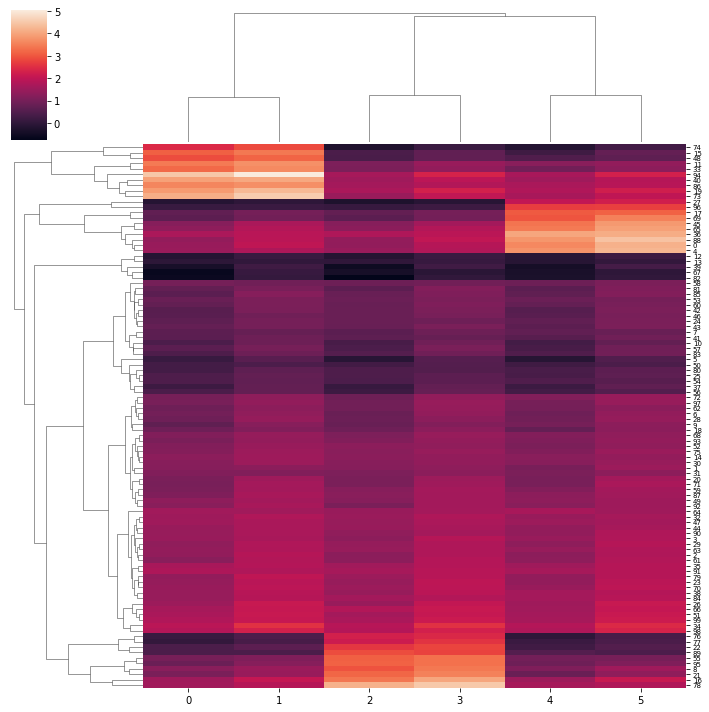

In [343]:
#Make heatmap with markers

g = sns.clustermap(np.log(concat_types),yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)


[Text(1, 0.5, '94'),
 Text(1, 1.5, '78'),
 Text(1, 2.5, '73'),
 Text(1, 3.5, '19'),
 Text(1, 4.5, '40'),
 Text(1, 5.5, '45'),
 Text(1, 6.5, '65'),
 Text(1, 7.5, '36'),
 Text(1, 8.5, '88'),
 Text(1, 9.5, '0'),
 Text(1, 10.5, '4'),
 Text(1, 11.5, '11'),
 Text(1, 12.5, '86'),
 Text(1, 13.5, '15'),
 Text(1, 14.5, '33'),
 Text(1, 15.5, '69'),
 Text(1, 16.5, '17'),
 Text(1, 17.5, '96'),
 Text(1, 18.5, '48'),
 Text(1, 19.5, '74'),
 Text(1, 20.5, '76'),
 Text(1, 21.5, '77'),
 Text(1, 22.5, '22'),
 Text(1, 23.5, '89'),
 Text(1, 24.5, '34'),
 Text(1, 25.5, '98'),
 Text(1, 26.5, '26'),
 Text(1, 27.5, '66'),
 Text(1, 28.5, '51'),
 Text(1, 29.5, '99'),
 Text(1, 30.5, '27'),
 Text(1, 31.5, '7'),
 Text(1, 32.5, '41'),
 Text(1, 33.5, '57'),
 Text(1, 34.5, '10'),
 Text(1, 35.5, '83'),
 Text(1, 36.5, '58'),
 Text(1, 37.5, '53'),
 Text(1, 38.5, '60'),
 Text(1, 39.5, '24'),
 Text(1, 40.5, '42'),
 Text(1, 41.5, '43'),
 Text(1, 42.5, '46'),
 Text(1, 43.5, '81'),
 Text(1, 44.5, '85'),
 Text(1, 45.5, '12'),
 

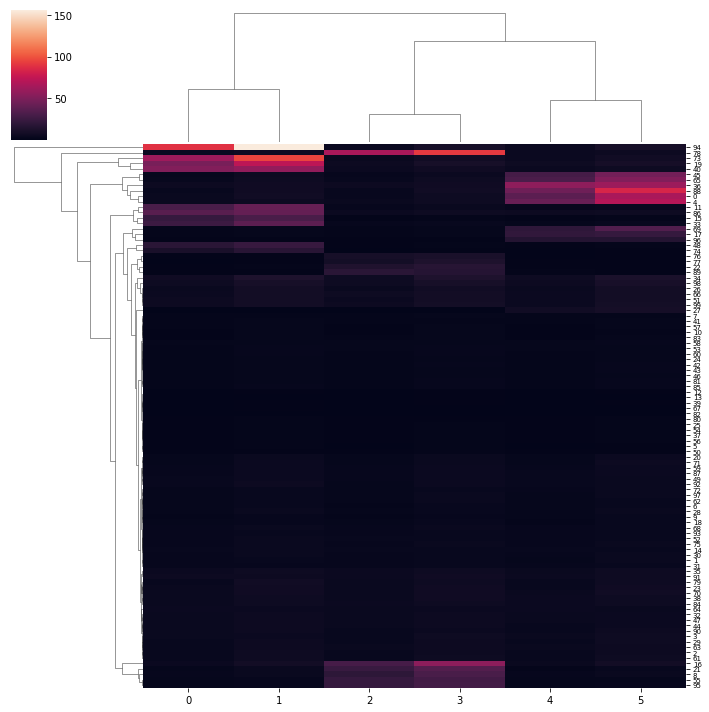

In [344]:
g = sns.clustermap(concat_types,yticklabels=True)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 7)
